## Importing the Class from the python file `image_authentication.py`

In [25]:
from image_authentication import ImageAuthenticityClassifier

## Class Instance and Initialization

In [26]:
classifier = ImageAuthenticityClassifier()

## Directories where the dataset is present

In [23]:
# Directories for dataset
train_dir = "data/train"
val_dir = "data/validate"
test_dir = "data/test"

## The Data is resized, rescaled and augmented

In [12]:
classifier.prepare_dataset(train_dir, val_dir, test_dir)

Found 96060 images belonging to 2 classes.
Found 3940 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


## Model design

In [13]:
classifier.build()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

None


## Training the model

In [14]:
classifier.train()

Epoch 1/20


/home/kirubakkar/anaconda3/envs/new_teachable/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3002/3002 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7898 - loss: 0.4524

/home/kirubakkar/anaconda3/envs/new_teachable/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3002/3002 ━━━━━━━━━━━━━━━━━━━━ 326s 108ms/step - accuracy: 0.7898 - loss: 0.4524 - val_accuracy: 0.9043 - val_loss: 0.2314
Epoch 2/20
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 310s 103ms/step - accuracy: 0.8866 - loss: 0.2774 - val_accuracy: 0.8992 - val_loss: 0.2405
Epoch 3/20
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 307s 102ms/step - accuracy: 0.9029 - loss: 0.2448 - val_accuracy: 0.9294 - val_loss: 0.1766
Epoch 4/20
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 306s 102ms/step - accuracy: 0.9086 - loss: 0.2300 - val_accuracy: 0.9343 - val_loss: 0.1690
Epoch 5/20
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 306s 102ms/step - accuracy: 0.9145 - loss: 0.2165 - val_accuracy: 0.9155 - val_loss: 0.2310
Epoch 6/20
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 305s 102ms/step - accuracy: 0.9198 - loss: 0.2099 - val_accuracy: 0.9061 - val_loss: 0.2273
Epoch 7/20
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 305s 102ms/step - accuracy: 0.9220 - loss: 0.2019 - val_accuracy: 0.9132 - val_loss: 0.2101
Epoch 8/20
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 305s 102ms/step - accuracy: 0.9

## Saving the trained model

In [17]:
classifier.save_model("genai_vs_original_model.keras")

Model saved to /home/kirubakkar/Kiruba/Umich/Sem_1/Pattern_recognition_and_Neural_Networks/GenAI_Image_vs_Original_Image/Implementation


## Training loss and Validation loss

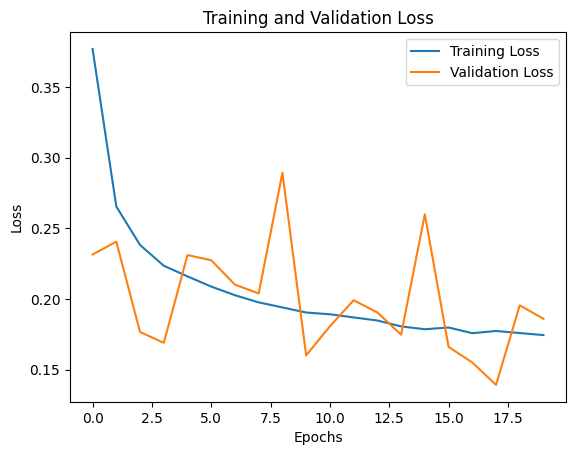

In [18]:
classifier.plot_loss()

## Training accuracy and Validation accuracy

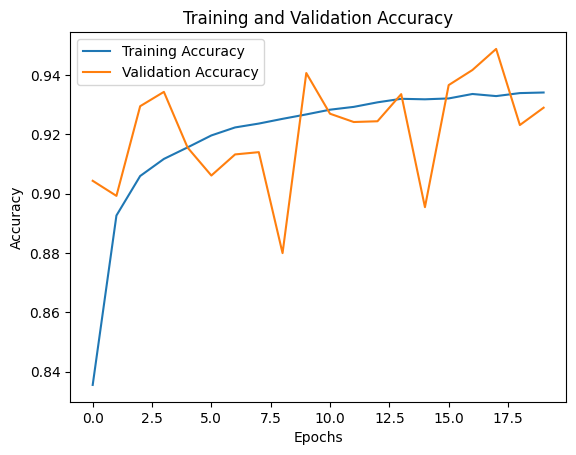

In [19]:
classifier.plot_accuracy()

## Model evaluation results - Test data accuracy , loss and F1 score

In [ ]:
classifier.evaluate()

/home/kirubakkar/anaconda3/envs/new_teachable/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9653 - loss: 0.0925
Test Loss: 0.1843
Test Accuracy: 0.9271
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step
F1 Score: 0.9227

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.88      0.98      0.93     10000
        REAL       0.98      0.87      0.92     10000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



## Sample testing

In [21]:
test_path = "data/test/FAKE/0.jpg"
prediction = classifier.predict_image(test_path)
print(f"The predicted image is {prediction[0]} with an accuracy of {prediction[1]*100}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
The predicted image is GenAI with an accuracy of 99.98412322998047%


In [22]:
test_path = "data/test/REAL/0033.jpg"
prediction = classifier.predict_image(test_path)
print(f"The predicted image is {prediction[0]} with an accuracy of {prediction[1]*100}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
The predicted image is Original with an accuracy of 97.67839050292969%
